In [5]:
%matplotlib inline
import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import warnings
warnings.filterwarnings('ignore')

In [6]:
from object_pose_utils.utils.display import *

## Select Object Indices of Interest

| Object Indices |[]()|[]()|
|---|---|---|
| __1.__ 002_master_chef_can | __8.__ 009_gelatin_box      | __15.__ 035_power_drill       |
| __2.__ 003_cracker_box     | __9.__ 010_potted_meat_can  | __16.__ 036_wood_block        |
| __3.__ 004_sugar_box       | __10.__ 011_banana          | __17.__ 037_scissors          |
| __4.__ 005_tomato_soup_can | __11.__ 019_pitcher_base    | __18.__ 040_large_marker      |
| __5.__ 006_mustard_bottle  | __12.__ 021_bleach_cleanser | __19.__ 051_large_clamp       |
| __6.__ 007_tuna_fish_can   | __13.__ 024_bowl            | __20.__ 052_extra_large_clamp |
| __7.__ 008_pudding_box     | __14.__ 025_mug             | __21.__ 061_foam_brick        |

In [7]:
from transforms3d.quaternions import quat2mat, mat2quat

def getPoseCNNQuat(data, obj):
    pose_idx = np.where(data['rois'][:,1].flatten()==obj)[0]
    if(len(pose_idx) == 0):
        return None
    else:
        pose_idx = pose_idx[0]
    pose = data['poses'][pose_idx]
    q = pose[:4][[1,2,3,0]]
    q /= np.linalg.norm(q)
    t = pose[4:7]
    return q


In [8]:
def evaluateFeature(model, objs, features,
                    grid_features = None,
                    grid_size = 3885):    
    num_features = features.shape[0]
    feature_size = features.shape[1]

    rep_indices = np.repeat(np.arange(num_features), grid_size)
    if(grid_features is not None):
        g_features = []
        for idx in objs:
            g_features.append(grid_features[idx.item()])
        g_features = torch.stack(g_features)

        lik_est = model(to_var(g_features.view(-1, feature_size)).cuda(),
                        to_var(features).cuda()[rep_indices])
        lik_est = lik_est.view(num_features, grid_size, -1).transpose(1,2)
    else:
        lik_est = model(to_var(features).cuda())
        lik_est = lik_est.view(num_features, -1, grid_size)
        
    if(lik_est.shape[1] > 1):
        obj_idxs = (objs.cuda()-1).view(-1,1,1).repeat(1, 1, grid_size)
        lik_est = lik_est.gather(1, obj_idxs)[:,0,:]
    else:
        lik_est = lik_est.view(num_features, grid_size)
    
    return lik_est

In [9]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.feature_dataset import FeatureDataset

from object_pose_utils.datasets.image_processing import ImageNormalizer
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
object_list = list(range(1,22))
mode = "test"

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.IMAGE_CROPPED, 
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES]



In [10]:
test_feature_root = '/scratch/bokorn/results/dense_fusion_local_feat_test/'
feature_root = '/scratch/bokorn/results/dense_fusion_global_feat/'
feature_key = 'feat_global'

reg_model_checkpoint = '/scratch/bokorn/results/log_lik/df_global_reg/{}/lr_1e-5/**/weights/final_*.pth'
feature_size = 1024

In [11]:
#feature_root = '/scratch/bokorn/results/posecnn_feat_all/'
#test_feature_root = feature_root
#feature_key = 'fc6'

#reg_model_checkpoint = '/scratch/bokorn/results/all_ycb/pcnn_fc6_grid/{}/trainval_no_augs/**/final_20001.pth'
#feature_size = 4096

shared_reg_model_checkpoint = '/scratch/bokorn/results/log_lik/df_global_reg/lr_1e-5/**/weights/checkpoint_*.pth'
feature_size = 1024
grid_size = 3885

model_checkpoint = sorted(glob.glob(shared_reg_model_checkpoint, recursive=True))[-1]
shared_estimator = SigmoidNet(feature_size, 21*grid_size)
shared_estimator.load_state_dict(torch.load(model_checkpoint))
shared_estimator.cuda();
shared_estimator.eval();

NameError: name 'glob' is not defined

In [7]:
from se3_distributions.models.compare_networks import SigmoidNet
from object_pose_utils.utils.interpolation import TetraInterpolation
tetra_interp = TetraInterpolation(2)


In [ ]:
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.image_processing import ImageNormalizer
from dense_fusion.network import PoseNet, PoseNetGlobal

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset/'
output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, otypes.IMAGE_CROPPED,
                 otypes.DEPTH_POINTS_MASKED_AND_INDEXES]

dataset = YCBDataset(dataset_root, mode='test',
                     object_list = list(range(1,22)),
                     output_data = output_format,
                     resample_on_error = False,
                     add_syn_background = False,
                     add_syn_noise = False,
                     use_posecnn_data=True,
                     postprocessors = [ImageNormalizer()],
                     image_size = [640, 480], num_points=1000)

In [154]:
from dense_fusion.network import PoseNet, PoseNetGlobal

df_weights = '/home/bokorn/src/DenseFusion/trained_checkpoints/ycb/pose_model_26_0.012863246640872631.pth'
df_estimator = PoseNet(num_points = 1000, num_obj = 21)
df_estimator.load_state_dict(torch.load(df_weights))
df_estimator.cuda();
df_estimator.eval();


df_global_weights = '/home/bokorn/src/DenseFusion/trained_models/ycb_global/pose_model_13_0.02780649198161978.pth'
df_global_estimator = PoseNetGlobal(num_points = 1000, num_obj = 21)
df_global_estimator.load_state_dict(torch.load(df_global_weights))
df_global_estimator.cuda();
df_global_estimator.eval();


In [176]:
estimator_idv = {}
for object_id in list(range(1,22)):
    model_checkpoint = sorted(glob.glob(reg_model_checkpoint.format(object_id), recursive=True))[-1]
    estimator_idv[object_id] = SigmoidNet(feature_size, grid_size)
    estimator_idv[object_id].load_state_dict(torch.load(model_checkpoint))
    estimator_idv[object_id].cuda();
    estimator_idv[object_id].eval();
    

IndexError: list index out of range

In [143]:
import glob
from se3_distributions.datasets.ycb_dataset import getYCBSymmeties
from object_pose_utils.utils.pose_processing import symmetricAngularDistance, meanShift

grid_size = 3885

for object_id in [13]:
    model_checkpoint = sorted(glob.glob(reg_model_checkpoint.format(object_id), recursive=True))[-1]
    estimator = SigmoidNet(feature_size, grid_size)
    estimator.load_state_dict(torch.load(model_checkpoint))
    estimator.cuda();
    estimator.eval();

    sym_axis, sym_ang = getYCBSymmeties(object_id)
    ycb_dataset = FeatureDataset(dataset_root = dataset_root,
                                 feature_root = test_feature_root,
                                 feature_key = feature_key,
                                 resample_on_error = False,
                                 mode=mode, object_list = [object_id])

    train_dataset = FeatureDataset(dataset_root = dataset_root,
                               feature_root = feature_root,
                               #feature_key = feature_key,
                               resample_on_error = False,
                               mode='train', object_list = [object_id])
    
    grid_vertices = torch.load(os.path.join(feature_root, 'grid',
        '{}_vertices.pt'.format(ycb_dataset.classes[object_id])))


In [ ]:
idx = np.random.randint(len(dataset))
data = dataset[idx]
obj, quat, img, points, choose = data
#print(obj)
imshowTorch(img, normalized=True)
plt.show()

df_obj_idx = obj - 1
img = img.unsqueeze(0).cuda()
points = points.unsqueeze(0).cuda()
choose = choose.unsqueeze(0).cuda()
df_obj_idx = df_obj_idx.unsqueeze(0).cuda()
#pred_r, pred_t, pred_c, emb, feat_local, feat = df_estimator.allFeatures(img, points, choose, df_obj_idx)
#lik_est = evaluateFeature(shared_estimator, obj, feat, None)
#scatterSO3(to_np(grid_vertices), to_np(lik_est[0]), [to_np(quat)])
#plt.show()

feat = df_global_estimator.globalFeature(img, points, choose, df_obj_idx)
lik_est = evaluateFeature(shared_estimator, obj, feat, None)
scatterSO3(to_np(grid_vertices), to_np(lik_est[0]), [to_np(quat)])
plt.show()

feat = df_global_estimator.globalFeature(img, points, choose, df_obj_idx)
lik_est = evaluateFeature(estimator_idv[obj.item()], obj, feat, None)
scatterSO3(to_np(grid_vertices), to_np(lik_est[0]), [to_np(quat)])
plt.show()

In [4]:
for data in ycb_dataset:
    obj, feat, quat = data
    break

#for train_data in train_dataset:
#    obj, feat, quat = train_data
#    break    
    
feat = to_var(feat).unsqueeze(0)
print(to_np(feat[0]))
lik_est = shared_estimator(feat)
lik_est = lik_est.view(1, -1, grid_size)

if(lik_est.shape[1] > 1):
    obj_idxs = (obj.cuda()-1).view(-1,1,1).repeat(1, 1, grid_size)
    lik_est = lik_est.gather(1, obj_idxs)[:,0,:]
else:
    lik_est = lik_est.view(num_features, grid_size)

print(to_np(lik_est[0]))

scatterSO3(to_np(grid_vertices), to_np(lik_est[0]), [to_np(quat)])
plt.show()

NameError: name 'ycb_dataset' is not defined

In [128]:
np.sum(to_np(lik_est[0])>.000005)

3

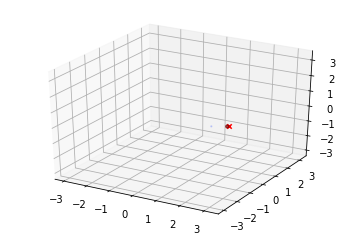

In [131]:
for train_data in train_dataset:
    break

    
obj, feat, quat = train_data
feat = to_var(feat).unsqueeze(0)

lik_est = estimator(feat)
scatterSO3(to_np(grid_vertices), to_np(lik_est[0]), [to_np(quat)])
plt.show()

In [106]:
model_checkpoint

'/scratch/bokorn/results/log_lik/df_global_reg/13/lr_1e-5/2019-09-03_05-55-38/weights/final_22001.pth'

In [24]:
ls /scratch/bokorn/results/dense_fusion_local_feat_test/data

0048/  0050/  0052/  0054/  0056/  0058/
0049/  0051/  0053/  0055/  0057/  0059/


In [ ]:
ls /scratch/bokorn/results/dense_fusion_global_feat/data/

In [30]:
from se3_distributions.datasets.ycb_dataset import getYCBSymmeties
from object_pose_utils.utils.pose_processing import symmetricAngularDistance, meanShift
import pathlib
import glob

import scipy.io as scio
from tqdm import tqdm_notebook as tqdm

grid_size = 3885

err_reg = {}
err_reg_max_shift = {}

lik_reg = {}

with torch.no_grad():
    for object_id in tqdm(object_list):
        model_checkpoint = sorted(glob.glob(reg_model_checkpoint.format(object_id), recursive=True))[-1]
        estimator_comp = SigmoidNet(feature_size, grid_size)
        estimator_comp.load_state_dict(torch.load(model_checkpoint))
        estimator_comp.cuda();
        
        sym_axis, sym_ang = getYCBSymmeties(object_id)
        ycb_dataset = FeatureDataset(dataset_root = dataset_root,
                                     feature_root = feature_root,
                                     feature_key = feature_key,
                                     resample_on_error = False,
                                     mode=mode, object_list = [object_id])
        grid_vertices = torch.load(os.path.join(feature_root, 'grid',
            '{}_vertices.pt'.format(ycb_dataset.classes[object_id])))

        grid_size = grid_vertices.shape[0]
        
        lik_reg[object_id] = []
        err_reg[object_id] = []
        err_reg_max_shift[object_id] = []
        
        pathlib.Path('results/data'.format(ycb_dataset.classes[object_id])).mkdir(parents=True, exist_ok=True)
        
        for j, data in tqdm(enumerate(ycb_dataset), total=len(ycb_dataset)):
            obj, feat, quat = data
            if(len(obj) == 0):
                lik_reg[object_id].append(np.nan)
                err_reg[object_id].append(np.nan)
                err_reg_max_shift[object_id].append(np.nan)
                continue
                
            feature_data = np.load('{}/data/{}_{}_feat.npz'.format(ycb_dataset.feature_root, 
                ycb_dataset.getPath(j), ycb_dataset.classes[obj]))

            feat = to_var(feat).unsqueeze(0)

            dist_est = estimator_comp(feat)
            dist_est = dist_est + dist_est.min()
            
            tetra_interp.setValues(to_np(dist_est.flatten()))
            
            lik_reg[object_id].append(tetra_interp.smooth(to_np(quat)).item())

            mode_quat = grid_vertices[torch.argmax(dist_est)].unsqueeze(0)
            
            v_shift = meanShift(mode_quat.cuda(), grid_vertices.cuda(), dist_est.t().cuda(),
                                sigma=np.pi/9, max_iter = 100)

            err_reg[object_id].append(symmetricAngularDistance(mode_quat, quat.unsqueeze(0),
                                             sym_axis, sym_ang).item()*180/np.pi)
            
            err_reg_max_shift[object_id].append(symmetricAngularDistance(v_shift.cpu(), quat.unsqueeze(0),
                                           sym_axis, sym_ang).item()*180/np.pi)
            
            savepath = 'results/{}'.format(ycb_dataset.getPath(j))
            pathlib.Path(savepath).mkdir(parents=True, exist_ok=True)
            
            scio.savemat('{}/{}_{}_clamp_reg_results_ROT.mat'.format(savepath, 
                                                    ycb_dataset.classes[object_id], 
                                                    ycb_dataset.feature_key),
                        {'index':j,
                         'quat':to_np(quat),
                         'mode_quat':to_np(mode_quat),
                         'dist_est':to_np(dist_est),
                         'lik_reg':lik_reg[object_id][-1],
                         'err_reg':err_reg[object_id][-1],
                         'err_reg_max_shift':err_reg_max_shift[object_id][-1],
                         })
np.savez('results/{}_clamp_reg_ROT.npz'.format(feature_key), 
         err_reg=err_reg,
         lik_reg=lik_reg,
         err_reg_max_shift=err_reg_max_shift)

Exception on index 49: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0050/000633_005_tomato_soup_can_feat.npz'
Exception on index 50: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0050/000640_005_tomato_soup_can_feat.npz'
Exception on index 51: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0050/000642_005_tomato_soup_can_feat.npz'
Exception on index 52: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0050/000644_005_tomato_soup_can_feat.npz'
Exception on index 54: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0050/000653_005_tomato_soup_can_feat.npz'
Exception on index 55: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0050/000660_005_tomato_soup_can_feat.npz'
Exception on index 57: [Errno 2] No such

Exception on index 638: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/000654_005_tomato_soup_can_feat.npz'
Exception on index 639: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/000663_005_tomato_soup_can_feat.npz'
Exception on index 640: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/000668_005_tomato_soup_can_feat.npz'
Exception on index 641: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/000686_005_tomato_soup_can_feat.npz'
Exception on index 642: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/000687_005_tomato_soup_can_feat.npz'
Exception on index 643: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/000702_005_tomato_soup_can_feat.npz'
Exception on index 644: [Errno 2] 

Exception on index 746: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/001366_005_tomato_soup_can_feat.npz'
Exception on index 747: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/001367_005_tomato_soup_can_feat.npz'
Exception on index 748: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/001369_005_tomato_soup_can_feat.npz'
Exception on index 749: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/001372_005_tomato_soup_can_feat.npz'
Exception on index 750: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/001374_005_tomato_soup_can_feat.npz'
Exception on index 751: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0055/001381_005_tomato_soup_can_feat.npz'
Exception on index 752: [Errno 2] 

Exception on index 87: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0049/000833_010_potted_meat_can_feat.npz'
Exception on index 108: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0049/001157_010_potted_meat_can_feat.npz'
Exception on index 111: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0049/001179_010_potted_meat_can_feat.npz'
Exception on index 115: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0049/001222_010_potted_meat_can_feat.npz'
Exception on index 116: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0049/001229_010_potted_meat_can_feat.npz'
Exception on index 118: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0049/001247_010_potted_meat_can_feat.npz'
Exception on index 129: [Errno 2] N

Exception on index 659: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0056/000973_035_power_drill_feat.npz'
Exception on index 661: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0056/000981_035_power_drill_feat.npz'
Exception on index 665: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0056/000996_035_power_drill_feat.npz'
Exception on index 666: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0056/001001_035_power_drill_feat.npz'
Exception on index 671: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0056/001036_035_power_drill_feat.npz'
Exception on index 672: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0056/001037_035_power_drill_feat.npz'
Exception on index 673: [Errno 2] No such file or director

Exception on index 174: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0051/001914_037_scissors_feat.npz'
Exception on index 175: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0051/001924_037_scissors_feat.npz'
Exception on index 176: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0051/001927_037_scissors_feat.npz'
Exception on index 177: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0051/001932_037_scissors_feat.npz'
Exception on index 178: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0051/001968_037_scissors_feat.npz'
Exception on index 179: [Errno 2] No such file or directory: '/scratch/bokorn/results/dense_fusion_local_feat_rot/data/0051/001990_037_scissors_feat.npz'
Exception on index 180: [Errno 2] No such file or directory: '/scratch/bokor

In [52]:
np.mean(np.array(err_reg[object_id]) - np.array(err_reg_max_shift[object_id]))

3.373728066048754

In [76]:
data = np.load('results/{}_reg.npz'.format(feature_key),allow_pickle=True)
list(data.keys())

['err_reg', 'lik_reg', 'err_reg_max_shift']

In [80]:
data['lik_reg'].item().keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [83]:

data = np.load('results/{}_reg.npz'.format('feat_global'),allow_pickle=True)
for obj in range(1,22):
    #plt.hist(lik_reg[obj])
    #plt.hist(err_reg_max_shift[obj], label='mean_shift')
    #plt.title(ycb_dataset.classes[obj])
    #plt.legend()
    print(ycb_dataset.classes[obj], np.nanmean(np.log(data['lik_reg'].item()[obj])), np.nanmean(np.abs(data['err_reg'].item()[obj])))
    #plt.show()

002_master_chef_can -0.38637696593374943 89.21374307303225
003_cracker_box 0.2073344222803132 34.75298934722838
004_sugar_box 0.5647517596515155 21.758722971707034
005_tomato_soup_can 0.19922652743448552 30.59064939936876
006_mustard_bottle 0.6591109769981284 22.392229298909417
007_tuna_fish_can -0.6963466226711283 63.956717026625284
008_pudding_box 0.08829368962914562 34.2539003075583
009_gelatin_box 0.47068790002708816 19.11330790263637
010_potted_meat_can 0.19027995031947453 42.29257989430809
011_banana -0.5164164642303877 107.39923927148072
019_pitcher_base 0.6234218152681478 20.745012691169425
021_bleach_cleanser 0.06553939053759832 40.0954395212358
024_bowl -2.662205887330869 93.77400535140387
025_mug -0.40896056599211705 51.996722843467666
035_power_drill 0.5864399404101668 20.502484676044656
036_wood_block -1.8468870705307472 39.220618093524045
037_scissors -2.293236754166506 156.46877397855144
040_large_marker -1.6386690858544586 105.87406753444176
051_large_clamp -2.280653296

/home/bokorn/src/se3_distributions/bpy/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


In [53]:
print(feature_key)
for obj in range(1,22):
    #plt.hist(lik_reg[obj])
    #plt.hist(err_reg_max_shift[obj], label='mean_shift')
    #plt.title(ycb_dataset.classes[obj])
    #plt.legend()
    print(obj, np.nanmean(np.log(lik_reg[obj])), np.nanmean(np.abs(err_reg[obj])))
    #plt.show()

feat_global
1 -0.38637696593374943 89.21374307303225
2 0.2073344222803132 34.75298934722838
3 0.5647517596515155 21.758722971707034
4 0.19922652743448552 30.59064939936876
5 0.6591109769981284 22.392229298909417
6 -0.6963466226711283 63.956717026625284
7 0.08829368962914562 34.2539003075583
8 0.47068790002708816 19.11330790263637
9 0.19027995031947453 42.29257989430809
10 -0.5164164642303877 107.39923927148072
11 0.6234218152681478 20.745012691169425
12 0.06553939053759832 40.0954395212358
13 -2.662205887330869 93.77400535140387
14 -0.40896056599211705 51.996722843467666
15 0.5864399404101668 20.502484676044656
16 -1.8468870705307472 39.220618093524045
17 -2.293236754166506 156.46877397855144
18 -1.6386690858544586 105.87406753444176
19 -2.2806532961147536 93.23679932792714
20 -1.7518456134817402 51.119386855604695
21 -2.6811071763674077 111.34690435916349


/home/bokorn/src/se3_distributions/bpy/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


In [45]:
for obj in range(1,22):
    #plt.hist(lik_reg[obj])
    #plt.hist(err_reg_max_shift[obj], label='mean_shift')
    #plt.title(ycb_dataset.classes[obj])
    #plt.legend()
    print(obj, np.nanmean(np.log(lik_reg[obj])), np.nanmean(np.abs(err_reg[obj])))
    #plt.show()

1 -2.318162620571506 148.45409228991755
2 -2.167720971654134 128.86390270066886
3 -2.2226806068874922 102.4797834771266
4 -2.0691215335898963 61.10336974449893
5 -2.1649429681668315 124.31680117468785
6 -2.360725631221771 101.37349081491017
7 -2.1018538120420702 99.07093843459529
8 -2.008700840178463 73.35644393246955
9 -2.168774829826751 58.51431964354313
10 -2.3112099092621365 146.45515587272652
11 -2.2613990524679743 65.84814259503719
12 -2.2755729649266447 128.44892773485608
13 -2.244938858039455 101.4411507325818
14 -2.280810022538222 148.52547428367913
15 -2.1152767075802785 116.12892108309474
16 -2.31866573975598 88.86746618850079
17 -2.1617013940494028 175.0310194632421
18 -2.1475126489030694 151.2793195178578
19 -2.3133350952862366 97.47797978588459
20 -2.1671224465987446 89.24118457625823
21 -2.2120569022249525 65.79263530127723


/home/bokorn/src/se3_distributions/bpy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [3]:
import numpy as np
sigmas = np.load('../notebooks/feat_global_sigma.npz')['sigmas']

In [5]:
from mpl_toolkits.mplot3d import Axes3D
cmap = plt.get_cmap('jet')
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
scatterSO3(to_np(grid_vertices), to_np(torch.exp(torch.log(dist_est.flatten())*np.pi/9/sigmas[object_id])),
           [to_np(quat)], alpha_max = .5)
tetra_interp.setValues(to_np(torch.exp(torch.log(dist_est.flatten())*np.pi/9/sigmas[object_id])))
print(tetra_interp.smooth(to_np(quat)))
tetra_interp.setValues(to_np(dist_est.flatten()))
print(tetra_interp.smooth(to_np(quat)))
#pt_gt = quats2Point([pcnn_quat])
#ax.scatter(pt_gt[:,0], pt_gt[:,1], pt_gt[:,2], c='K', marker='x')

NameError: name 'plt' is not defined

In [4]:
sigmas

array([0.10484988, 0.00935838, 0.16386687, 0.06837537, 0.22288387,
       0.12739236, 0.03190086, 0.18640936, 0.09091786, 0.24542635,
       0.14993485, 0.05444335, 0.20895184, 0.11346034, 0.01796884,
       0.17247734, 0.07698583, 0.23149433, 0.13600283, 0.04051133,
       0.19501982, 0.09952832, 0.00403682, 0.15854531, 0.06305381,
       0.21756231, 0.12207081, 0.0265793 , 0.1810878 , 0.0855963 ,
       0.24010479, 0.14461329, 0.04912179, 0.20363029, 0.10813878,
       0.01264728, 0.16715578, 0.07166427, 0.22617277, 0.13068127,
       0.03518977, 0.18969826, 0.09420676, 0.24871526, 0.15322375,
       0.05773225, 0.21224075, 0.11674925, 0.02125774, 0.17576624,
       0.08027474, 0.23478324, 0.13929173, 0.04380023, 0.19830873,
       0.10281722, 0.00732572, 0.16183422, 0.06634272, 0.22085121,
       0.12535971, 0.02986821, 0.1843767 , 0.0888852 , 0.2433937 ,
       0.1479022 , 0.05241069, 0.20691919, 0.11142769, 0.01593618,
       0.17044468, 0.07495318, 0.22946168, 0.13397017, 0.03847